In [2]:
import tensorflow as tf
import numpy as np
import tensorflow.keras as keras
import pandas as pd
import os
from keras import layers

from data_processing import *
from training_utils import *



In [21]:
MODEL_WEIGHTS_PATH="local_runs/L_size_model/04-13-12:23_model_emd1028_DH4_EH4_EPS10_LR0.0001.h5"
MODEL_CONFIG_PATH="local_runs/L_size_model/trial_config.json"
TOKENIZER_PATH="local_runs/L_size_model/tokenizer.keras"

In [22]:
with open(MODEL_CONFIG_PATH, "r") as f:
    CONFIG = json.load(f)
    

In [23]:
CONFIG

{'TIMESTAMP': '04-13-12:23',
 'DATA_PATH': 'data/flickr30k_images/',
 'IMAGES_PATH': 'data/flickr30k_images/flickr30k_images/',
 'IMAGE_SIZE': [224, 224],
 'VAL_FRACTION': 0.05,
 'SEQ_LENGTH': 36,
 'VOCAB_SIZE': 10000,
 'BATCH_SIZE': 128,
 'STRIP_CHARS': '!"#$%&\'()*+,-./:;=?@[\\]^_`{|}~',
 'EPOCHS': 10,
 'EMBED_DIM': 1028,
 'FF_DIM': 512,
 'ENC_HEADS': 4,
 'DEC_HEADS': 4,
 'ARTIFACT_DIR': './local_runs/L_size_model',
 'LR': 0.0001}

In [24]:
model = load_trained_model_weights(MODEL_WEIGHTS_PATH, CONFIG)

In [25]:
model.summary()

Model: "image_captioning_model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 model_2 (Functional)        (None, 49, 1280)          6575239   
                                                                 
 transformer_encoder_block_  multiple                  18243392  
 2 (TransformerEncoderBlock                                      
 )                                                               
                                                                 
 transformer_decoder_block_  multiple                  55511204  
 2 (TransformerDecoderBlock                                      
 )                                                               
                                                                 
Total params: 80329839 (306.43 MB)
Trainable params: 73754596 (281.35 MB)
Non-trainable params: 6575243 (25.08 MB)
___________________________________________________________

In [26]:
tokenizer = load_tokenizer(TOKENIZER_PATH)

In [27]:
caption_model = model

In [28]:
val_captionings_df = pd.read_csv("splits/val_captions.csv")

vocab = tokenizer.get_vocabulary()
index_lookup = dict(zip(range(len(vocab)), vocab))
max_decoded_sentence_length = CONFIG["SEQ_LENGTH"] - 1
valid_images = val_captionings_df.iloc[1: 1000]["image_name"].to_list()

import matplotlib.pyplot as plt
def generate_caption():
    # Select a random image from the validation dataset
    sample_img = np.random.choice(valid_images)

    # Read the image from the disk
    sample_img = decode_and_resize(sample_img, CONFIG["IMAGE_SIZE"])
    img = sample_img.numpy().clip(0, 255).astype(np.uint8)
    plt.figure(figsize=(6, 6))
    plt.imshow(img / 255.0)
    

    # Pass the image to the CNN
    img = tf.expand_dims(sample_img, 0)
    
    img = caption_model.cnn_model(img)

    
    
    # Pass the image features to the Transformer encoder
    encoded_img = caption_model.encoder(img, training=False)

    # Generate the caption using the Transformer decoder
    decoded_caption = "<start> "
    for i in range(max_decoded_sentence_length):
        tokenized_caption = tokenizer([decoded_caption])[:, :-1]
        mask = tf.math.not_equal(tokenized_caption, 0)
        predictions = caption_model.decoder(
            tokenized_caption, encoded_img, training=False, mask=mask
        )
        sampled_token_index = np.argmax(predictions[0, i, :])
        sampled_token = index_lookup[sampled_token_index]
        if sampled_token == "end":
            break
        decoded_caption += " " + sampled_token

    decoded_caption = decoded_caption.replace("<start> ", "")
    decoded_caption = decoded_caption.replace("end", "").strip()
    print("Predicted Caption: ", decoded_caption)

    plt.show()

Predicted Caption:  a man in a black jacket is holding a [UNK] and smiling


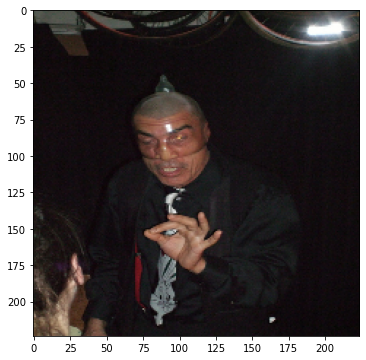

Predicted Caption:  a man is standing on a stage with a crowd of people


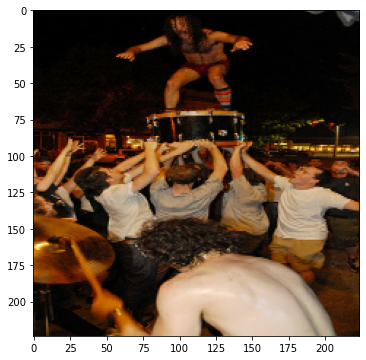

Predicted Caption:  a man is taking a picture of a young woman


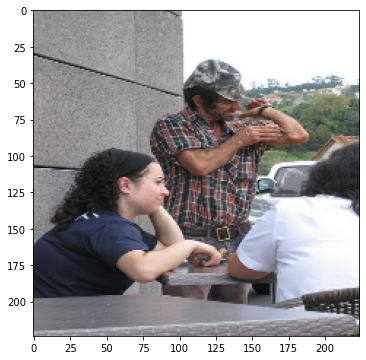

Predicted Caption:  three people are sitting on a bench and one is looking down at something in her lap


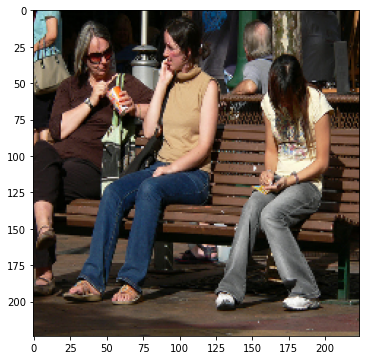

Predicted Caption:  two people are standing on the beach in the ocean


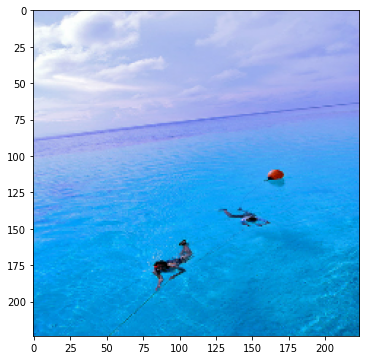

Predicted Caption:  a group of people are sitting on a deck


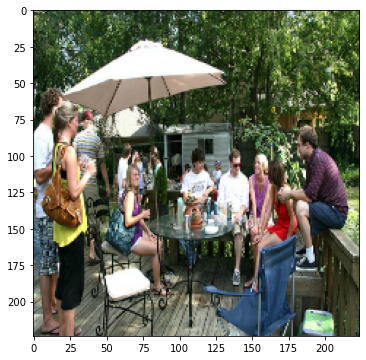

Predicted Caption:  two men are working on a tile floor


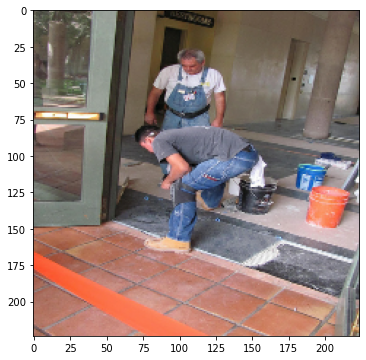

Predicted Caption:  a group of people are playing drums


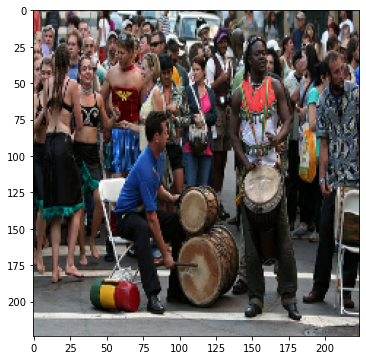

Predicted Caption:  two people standing in a hot tub


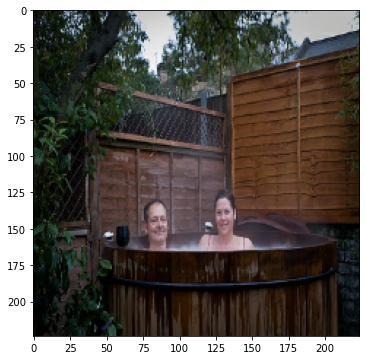

Predicted Caption:  a black dog and a white dog is running through a river


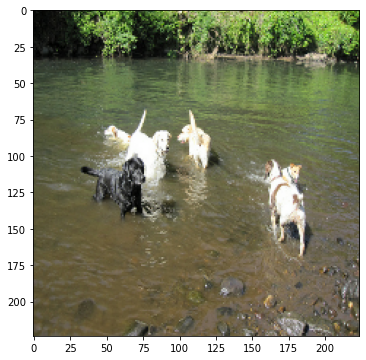

Predicted Caption:  two boats are being driven by a river with a man in the background


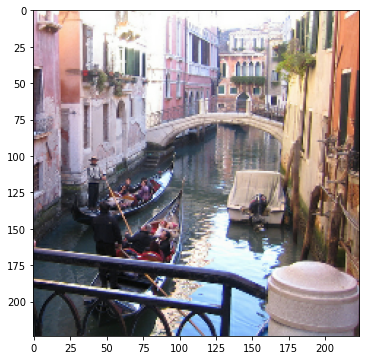

Predicted Caption:  a woman with brown hair and a white shirt is looking at something


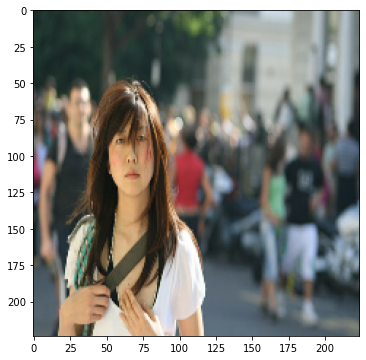

Predicted Caption:  a woman in a blue shirt is taking a picture of her fri


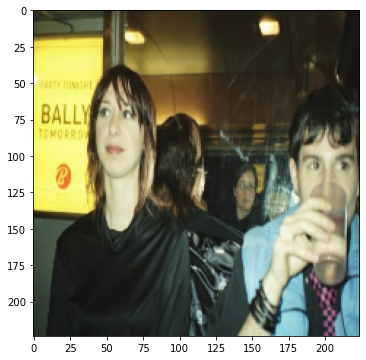

Predicted Caption:  a dog jumps through a fire


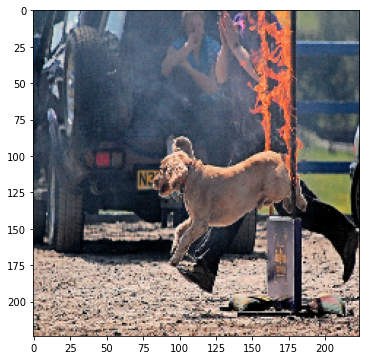

Predicted Caption:  a group of people are gathered around a room


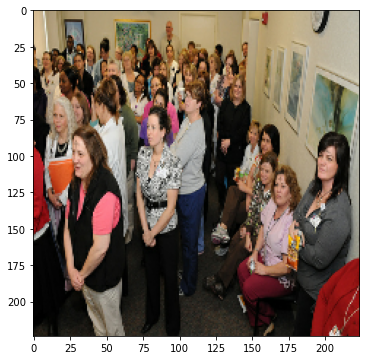

Predicted Caption:  a man is sitting on a bench


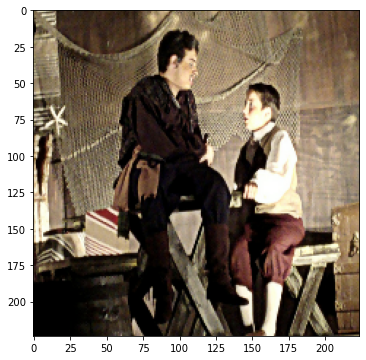

Predicted Caption:  a man on a dirt bike is riding on a dirt track


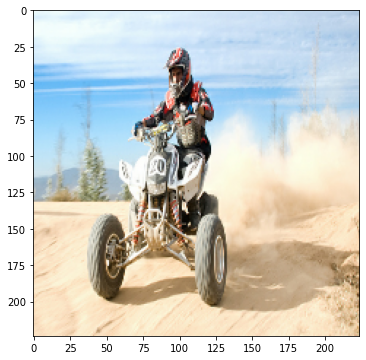

Predicted Caption:  two men play guitar on a boat


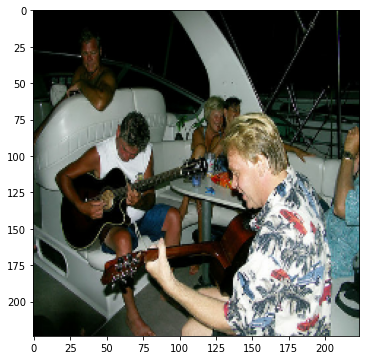

Predicted Caption:  a man is sliding down a slide


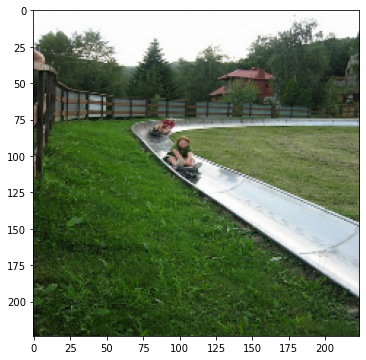

Predicted Caption:  people are shopping in a supermarket


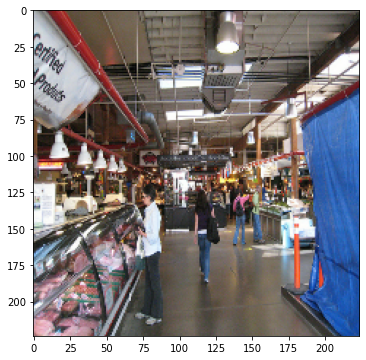

In [29]:
N_TO_GENERATE = 20

for _ in range(N_TO_GENERATE):
    generate_caption()